# Little's Power Law Data Analysis    
In this notebook I will explore answers to questions that have bothered me in my software delivery role. Why I cannot use vanilla Little's Law to predict / forecast when piece of work will be ready, and what can I do to make it useful. 

### Little's Law
$LT=TH*WIP$
where LT is lead time (total time), TH is throughput (cycle time) and WIP is work in progress (commited work in the queue). Assumption that is made under Little's law is that system is stable i.e. mean and variance do not change over time and work cannot halt to be resumed later.  

The problem is that this is not the case with knowledge work, as mean and variance can drastically shift when work "goes long" creating thick tails and work can be halted and resumed later. 

### Data Background
"Sprint Team" anonymised data was kindly provided by one of my employers. Data represents 1 feature team over 1 year period.

## Initial data analysis 

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('bmh')

sprints = pd.read_csv("sprintTeam.csv")
sprints["CycleTime"] = sprints["CycleTime"]+1
sprints["LeadTime"] = sprints["LeadTime"]+1
display(sprints.head())

,Sprint,CycleTime,LeadTime
0,A,2,5
1,A,4,11
2,A,7,11
3,A,1,11
4,A,5,11


In [3]:
sprints.describe()

,CycleTime,LeadTime
count,516.000000,516.000000
mean,5.449612,9.447674
std,4.315178,4.520415
min,1.000000,2.000000
25%,2.000000,7.000000
50%,4.000000,9.000000
75%,8.000000,11.000000
max,35.000000,40.000000


<AxesSubplot:ylabel='Frequency'>

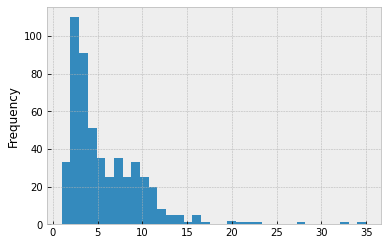

In [4]:
sprints["CycleTime"].plot(kind="hist", bins=35)

<AxesSubplot:ylabel='Frequency'>

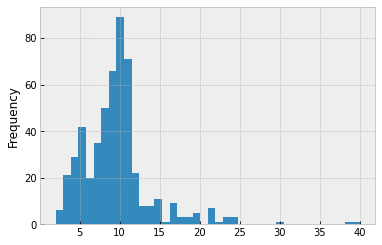

In [5]:
sprints["LeadTime"].plot(kind="hist", bins=40)

In [6]:
sprints_workitem_count = sprints.groupby('Sprint').agg(Count =('Sprint', 'count'))
sprints_workitem_count = sprints_workitem_count.reset_index()
sprints_workitem_count.describe()

,Count
count,26.000000
mean,19.846154
std,6.149421
min,5.000000
25%,16.000000
50%,19.000000
75%,24.000000
max,33.000000


<AxesSubplot:ylabel='Frequency'>

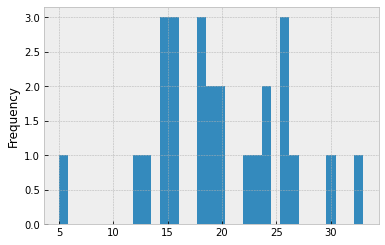

In [7]:
sprints_workitem_count["Count"].plot(kind="hist", bins=33)

## Looking at the log scale of distribution

In [8]:
sprints_log = sprints.copy(deep=True)
sprints_log["CycleTime"] = np.log10(sprints["CycleTime"])
sprints_log["LeadTime"] = np.log10(sprints["LeadTime"])
sprints_log.describe()

,CycleTime,LeadTime
count,516.000000,516.000000
mean,0.620401,0.929256
std,0.320001,0.205776
min,0.000000,0.301030
25%,0.301030,0.845098
50%,0.602060,0.954243
75%,0.903090,1.041393
max,1.544068,1.602060


In [9]:
display(sprints_log.head())

,Sprint,CycleTime,LeadTime
0,A,0.301030,0.698970
1,A,0.602060,1.041393
2,A,0.845098,1.041393
3,A,0.000000,1.041393
4,A,0.698970,1.041393


<AxesSubplot:ylabel='Frequency'>

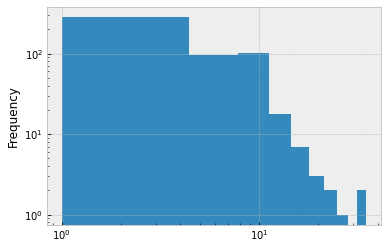

In [10]:
sprints["CycleTime"].plot(kind="hist", logy=True, logx=True)

<AxesSubplot:ylabel='Frequency'>

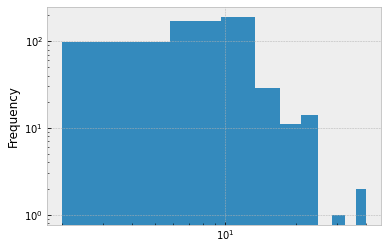

In [11]:
sprints["LeadTime"].plot(kind="hist", logx=True, logy=True)

## Finding distribution

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 45.92it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,0.643274,1066.674897,-3438.149881,inf,0.137322,5.988130e-09
lognorm,0.648099,1029.108214,-3428.048063,inf,0.112849,3.521478e-06
exponpow,0.666034,1059.180107,-3413.962713,inf,0.168959,2.400026e-13
chi2,0.683279,1192.999674,-3400.772249,inf,0.237677,3.944274e-26
cauchy,0.715876,1077.947455,-3382.971156,inf,0.220051,2.012268e-22


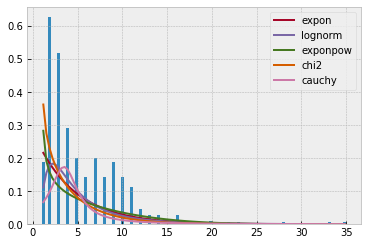

In [12]:

from fitter import Fitter, get_common_distributions, get_distributions

f_cycle = Fitter(sprints["CycleTime"].values, distributions=get_common_distributions())
f_cycle.fit()
f_cycle.summary()

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 50.76it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
cauchy,0.445269,1025.778265,-3627.982050,inf,0.096007,1.365415e-04
rayleigh,0.463697,1397.760322,-3607.057660,inf,0.170400,1.438633e-13
norm,0.463908,1733.654458,-3606.822156,inf,0.196918,5.232667e-18
lognorm,0.464479,1156.635233,-3599.941800,inf,0.133319,1.852778e-08
gamma,0.465260,1198.585606,-3599.074936,inf,0.140849,2.152095e-09


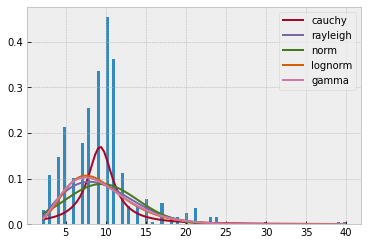

In [13]:
f_lead = Fitter(sprints["LeadTime"].values, distributions=get_common_distributions())
f_lead.fit()
f_lead.summary()

Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.938405,725.651244,-453.058829,inf,0.105801,0.198328
norm,0.938410,723.367728,-457.663511,inf,0.106942,0.188781
gamma,0.939241,724.408528,-452.969807,inf,0.109746,0.166846
chi2,0.939578,724.060517,-452.933902,inf,0.113392,0.141395
cauchy,0.939971,783.667259,-457.497316,inf,0.121179,0.097495


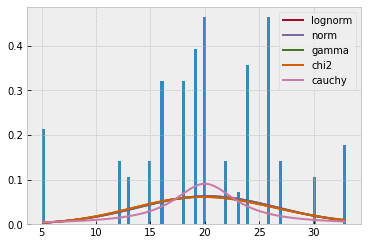

In [172]:

f_wip = Fitter(np.random.choice(sprints_workitem_count["Count"].values, 100), distributions=get_common_distributions())
f_wip.fit()
f_wip.summary()

For cycle time and lead time lognormal distributions are choosen as they should not overfit and adjust well as new data is added. 

## Fitting to data

### Cycle Time

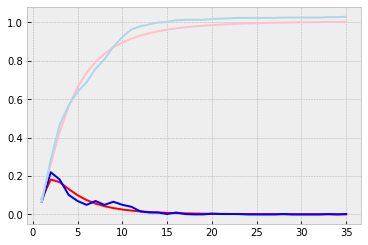

In [24]:
from pylab import linspace
import scipy.stats as stats

cycle_dist = stats.lognorm
cycle_min = int(sprints.describe().CycleTime["min"])
cycle_max = int(sprints.describe().CycleTime["max"])
X = linspace(cycle_min, cycle_max, cycle_max)

cycle_fitted = cycle_dist.pdf(X, *f_cycle.fitted_param['lognorm'])
cycle_cumulative = np.cumsum(cycle_fitted)

cycle_actual,  cycle_actual_bins = np.histogram(sprints["CycleTime"].values, bins=cycle_max, density=True)
cycle_cumulative_actual = np.cumsum(cycle_actual)

plt.plot(X, cycle_fitted, c='red')
plt.plot(X, cycle_actual, c='blue')

plt.plot(X, cycle_cumulative, c='pink')
plt.plot(X, cycle_cumulative_actual, c='lightblue')
plt.show()

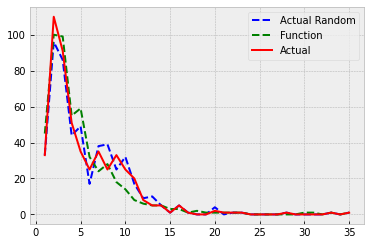

In [25]:
cycle_fitted_discretized = np.copy(cycle_fitted)
p_overflow = (cycle_cumulative[-1:]-1.0)[0]
p_max_index = np.argmax(cycle_fitted)
cycle_fitted_discretized[p_max_index] -= p_overflow

actual_sample = np.random.choice(sprints["CycleTime"].values, 516)
actual, bins = np.histogram(actual_sample, bins=cycle_max)

function_sample = np.random.choice(X, 516, p=cycle_fitted_discretized)
simulated, bins = np.histogram(function_sample, bins=cycle_max)

plt.plot(X, actual, 'b--', label="Actual Random")
plt.plot(X, simulated, 'g--', label="Function")
plt.plot(X, np.histogram(sprints["CycleTime"].values, bins=cycle_max)[0], "r",label="Actual")
plt.legend()
plt.show()


In [17]:
hist_obs = np.histogram(function_sample, bins=cycle_max)[0]+1
hist_exp = np.histogram(actual_sample, bins=cycle_max)[0]+1
hist_exp_act = np.histogram(sprints["CycleTime"].values, bins=cycle_max)[0]+1

print("Lognorm p-values", "Chi: ", stats.chisquare(f_obs=hist_exp, f_exp=hist_obs)[1], "KS: ", stats.ks_2samp(actual_sample, function_sample)[1])
print("Control p-values", "Chi: ", stats.chisquare(f_obs=hist_exp, f_exp=hist_exp_act)[1], "KS: ", stats.ks_2samp(actual_sample, sprints["CycleTime"].values)[1])

Lognorm p-values Chi:  0.0 KS:  0.43345565602374597
Control p-values Chi:  0.9999852852726482 KS:  0.9998097524081347


### Lead Time

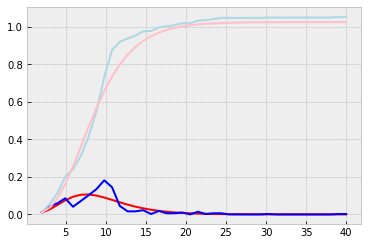

In [26]:
lead_dist = stats.lognorm
lead_min = int(sprints.describe().LeadTime["min"])
lead_max = int(sprints.describe().LeadTime["max"])
X = linspace(lead_min, lead_max, lead_max)

lead_fitted = lead_dist.pdf(X, *f_lead.fitted_param['lognorm'])
lead_cumulative = np.cumsum(lead_fitted)

lead_actual, lead_actual_bins = np.histogram(sprints["LeadTime"].values, bins=lead_max, density=True)
lead_cumulative_actual = np.cumsum(lead_actual)


plt.plot(X, lead_fitted, c='red')
plt.plot(X, lead_actual, c='blue')

plt.plot(X, lead_cumulative_actual, c='lightblue')
plt.plot(X, lead_cumulative, c='pink')
plt.show()

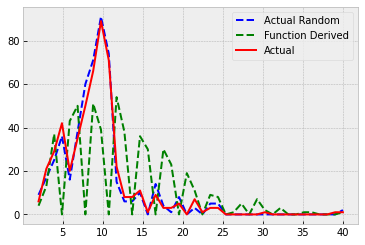

In [38]:
lead_fitted_discretized = np.copy(lead_fitted)
p_overflow = (lead_cumulative[-1:]-1.0)[0]
p_max_index = np.argmax(lead_fitted)
lead_fitted_discretized[p_max_index] -= p_overflow

actual_sample = np.random.choice(sprints["LeadTime"].values, 516)
actual, bins = np.histogram(actual_sample, bins=lead_max)

function_sample = np.random.choice(X, 516, p=lead_fitted_discretized)
simulated, bins = np.histogram(function_sample, bins=lead_max)

plt.plot(X, actual, "b--", label="Actual Random")
plt.plot(X, simulated, 'g--', label="Function Derived")
plt.plot(X, np.histogram(sprints["LeadTime"].values, bins=lead_max)[0], "r", label="Actual")
plt.legend()
plt.show()


In [28]:
hist_obs = np.histogram(function_sample, bins=lead_max)[0]+1
hist_exp = np.histogram(actual_sample, bins=lead_max)[0]+1
hist_exp_act = np.histogram(sprints["LeadTime"].values, bins=lead_max)[0]+1

print("Lognorm p-values", "Chi: ", stats.chisquare(f_obs=hist_exp, f_exp=hist_obs)[1], "KS: ", stats.ks_2samp(actual_sample, function_sample)[1])
print("Control p-values", "Chi: ", stats.chisquare(f_obs=hist_exp, f_exp=hist_exp_act)[1], "KS: ", stats.ks_2samp(actual_sample, sprints["LeadTime"].values)[1])

Lognorm p-values Chi:  0.0 KS:  6.384840531457563e-05
Control p-values Chi:  2.633270209438861e-10 KS:  0.9914321257355856


Despite of low p-values for cycle time, CDF looks close, data simulations are showing similiar data distribution and KS test at times comes back with 0.5. 

Same cannot be said for lead time, lead time has a multimodal distribution making it hard to fit it to common distributions. Lognorm covers data fairly well, however it under-represent the second modal, Cauchy represents the peak however it under-represents first modal. Lead time has two factors "time spent in the queue" and "cycle time". To make modelling better "time spent in the queue" will be extracted and used instead. 


### WIP 

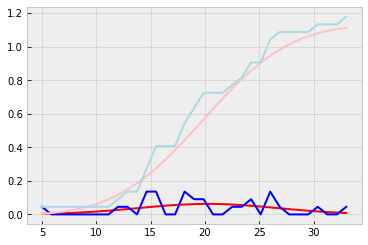

In [175]:
wip_dist = stats.norm
wip_min = int(sprints_workitem_count.describe().Count["min"])
wip_max = int(sprints_workitem_count.describe().Count["max"])

X = linspace(wip_min, wip_max, wip_max)
wip_fitted = wip_dist.pdf(X, *f_wip.fitted_param['norm'])
wip_cumulative = np.cumsum(wip_fitted)

wip_actual,  wip_actual_bins = np.histogram(sprints_workitem_count["Count"].values, bins=wip_max, density=True)
wip_cumulative_actual = np.cumsum(wip_actual)

#X is different to Y, this needs to be fixed in all of the samples
plt.plot(X, wip_fitted, c='red')
plt.plot(X, wip_actual, c='blue')

plt.plot(X, wip_cumulative, c='pink')
plt.plot(X, wip_cumulative_actual, c='lightblue')
plt.show()

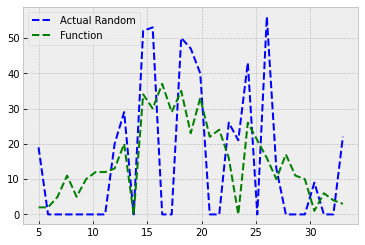

In [174]:
wip_fitted_discretized = np.copy(wip_fitted)
p_overflow = (wip_cumulative[-1:]-1.0)[0] 
p_overflow = p_overflow / wip_max
wip_fitted_discretized = wip_fitted_discretized - p_overflow 

actual_sample = np.random.choice(sprints_workitem_count["Count"].values, 500)
actual, bins = np.histogram(actual_sample, bins=wip_max)

function_sample = np.random.choice(X, 500, p=wip_fitted_discretized)
simulated, bins = np.histogram(function_sample, bins=wip_max)

plt.plot(X, actual, 'b--', label="Actual Random")
plt.plot(X, simulated, 'g--', label="Function")
plt.legend()
plt.show()

## Extracting Wait Time

In [177]:
sprints["Wait"] = sprints["LeadTime"] - sprints["CycleTime"]
sprints["Wait"].describe()


count    516.000000
mean       3.998062
std        2.784492
min        0.000000
25%        1.000000
50%        4.000000
75%        6.000000
max       11.000000
Name: Wait, dtype: float64

<AxesSubplot:ylabel='Frequency'>

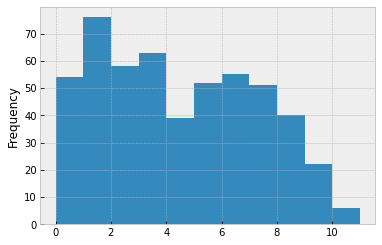

In [179]:
sprints["Wait"].plot(kind="hist", bins=11)

<AxesSubplot:ylabel='Frequency'>

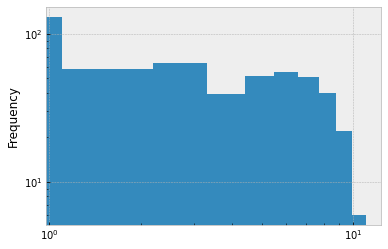

In [180]:
sprints["Wait"].plot(kind="hist", logy=True, logx=True)

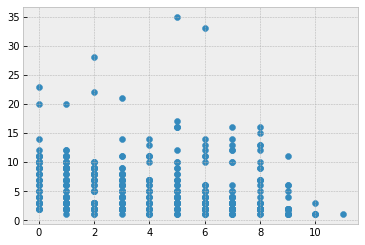

In [186]:
plt.scatter(sprints["Wait"], sprints["CycleTime"])
plt.show()


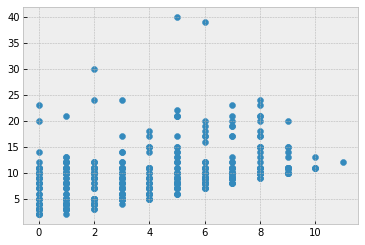

In [187]:
plt.scatter(sprints["Wait"], sprints["LeadTime"])
plt.show()